In [1]:
import numpy as np
import osmnx as ox
import networkx as nx 
import pandas as pd 
import matplotlib.pyplot as plt
import copy 
import geopandas as gpd
%matplotlib inline

## Download graph

In [2]:
#Файл можно скачать на сайте OpenStreetMap --> Экспорт --> Навестись на область карты --> кликнуть Overpass Api
# osm_file_path = "/home/igoreshka/Downloads/map (2)"
# graph = ox.graph_from_xml(osm_file_path, simplify=True)

city_name = 'Vladivostok, Russia'
graph = ox.graph_from_place(city_name)

# ox.plot_graph(ox.project_graph(graph))

## Graph description

In [3]:
# for u, v, key, edge_data in graph.edges(keys=True, data=True):
#     if 'length' not in edge_data.keys() :
#         print(edge_data)

nodes_x_y = []
for node in graph.nodes():
    info_node = graph.nodes[node]
    nodes_x_y.append((info_node['x'],info_node['y']))
nodes_x_y = np.array(nodes_x_y)
[graph_min_x,graph_min_y] = np.min(nodes_x_y,axis=0)
[graph_max_x ,graph_max_y] = np.max(nodes_x_y,axis=0)
print("min_x ,min_y =", graph_min_x,graph_min_y)
print("max_x ,max_y =",graph_max_x ,graph_max_y)

min_x ,min_y = 131.8413495 43.0578806
max_x ,max_y = 132.2312957 43.2880725


In [4]:
# for u, v, key, edge_data in graph.edges(keys=True, data=True):
#     print(edge_data.keys())


## Данные о жителях

С openstreetmap : (Пока не используем)

In [5]:

# buildings = ox.features.features_from_bbox( graph_max_y ,graph_min_y , graph_max_x , graph_min_x ,tags={'building':True}) #Примерно то что нужно
# buildings = ox.features.features_from_address(city_name , tags={'building':True}) тоже некорректно выдает город
# buildings = ox.geometries.geometries_from_address(city_name , tags={'building':True}) Устарело

In [6]:
# coords = np.array(buildings['geometry'].get_coordinates())
# [min_x,min_y] = np.min(coords,axis=0)
# [max_x ,max_y] = np.max(coords,axis=0)
# print("min_x ,min_y =", min_x,min_y)
# print("max_x ,max_y =",max_x ,max_y)

In [7]:
# plt.scatter(coords[:,0],coords[:,1])
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title(city_name)
# plt.show()

Из датасета (вся Россия)

In [8]:
file_path = '~/Downloads/data.csv'
buildings_2 = pd.read_csv(file_path)

/tmp/ipykernel_983464/4268506079.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  buildings_2 = pd.read_csv(file_path)


In [9]:
# plt.scatter(buildings_2['longitude'], buildings_2['latitude'])
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Россия')
# plt.show()

Отрежем конкретный город

In [10]:
builds_filtered = buildings_2[ buildings_2['longitude'] >= graph_min_x ][ buildings_2['longitude'] <=graph_max_x ][ buildings_2['latitude'] >= graph_min_y ][ buildings_2['latitude'] <=graph_max_y ]
builds_filtered = builds_filtered[builds_filtered['appartments'] > 0]

/tmp/ipykernel_983464/3022995213.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  builds_filtered = buildings_2[ buildings_2['longitude'] >= graph_min_x ][ buildings_2['longitude'] <=graph_max_x ][ buildings_2['latitude'] >= graph_min_y ][ buildings_2['latitude'] <=graph_max_y ]


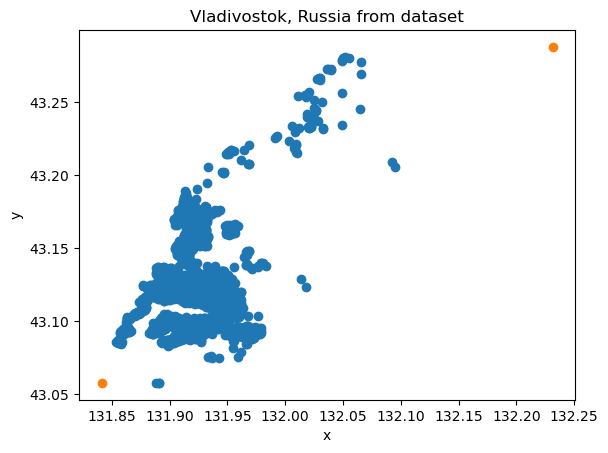

In [11]:

plt.scatter(builds_filtered['longitude'], builds_filtered['latitude'])
plt.scatter([graph_min_x , graph_max_x],[graph_min_y, graph_max_y])
plt.xlabel('x')
plt.ylabel('y')
plt.title(city_name + ' from dataset')
plt.show()

## Добавим разбиение города по районам (определяемых числом жителей)

In [12]:
builds_lon = (graph_min_x,graph_max_x)
builds_lat = (graph_min_y , graph_max_y)
builds_f = builds_filtered[['latitude' , 'longitude', 'appartments']]
builds_f.head()

,latitude,longitude,appartments
673,43.163696,131.954942,170.0
766,43.095322,131.969702,44.0
1228,43.166774,131.906963,83.0
1260,43.240519,132.022873,4.0
1353,43.143591,131.909721,54.0


In [13]:
builds_f.shape

(1985, 3)

In [14]:
def get_cell(df, lon, lat):
    if 'longitude' in df.keys() :
        return df[(df['longitude'] > lon[0]) & (df['longitude'] < lon[1]) & (df['latitude'] > lat[0]) & (df['latitude'] < lat[1])]
    else :
        return df[(df['lon'] > lon[0]) & (df['lon'] < lon[1]) & (df['lat'] > lat[0]) & (df['lat'] < lat[1])]
get_cell(builds_f,builds_lon,builds_lat).head()

,latitude,longitude,appartments
673,43.163696,131.954942,170.0
766,43.095322,131.969702,44.0
1228,43.166774,131.906963,83.0
1260,43.240519,132.022873,4.0
1353,43.143591,131.909721,54.0


In [15]:
import seaborn as sns
import plotly.express as px
emp = pd.read_csv('./data/emps.csv', sep='\t')
emp['post_codes'] = emp.address.apply(lambda x : x.split(',')[0])
emp_pcodes = emp[['post_codes', 'emp']].groupby('post_codes').sum()['emp']
emp_pcodes = pd.to_numeric(emp_pcodes, 'coerce').dropna()
# px.histogram(emp_pcodes, nbins=216)
# sns.boxplot(emp_pcodes)

In [16]:
R = 6371 * 1000
ax = R * np.pi / 180 * np.cos((emp.lat * np.pi / 180).mean()) 
emp['x'] = emp.lon * ax
ay = R * np.pi / 180
emp['y'] = emp.lat * ay
emp.x = emp.x  -570e6
emp.y = emp.y - 270e6
emp['size'] = emp.emp.apply(lambda x: x**0.5)

d_inv = {
    0: 'Советский',
    1: 'Первореченский',
    2: 'Ленинский',
    3: np.NaN,
    4: 'Фрунзенский',
    5: 'Первомайский'
}
d = {v: k for k, v in d_inv.items()}
d_inv



{0: 'Советский',
 1: 'Первореченский',
 2: 'Ленинский',
 3: nan,
 4: 'Фрунзенский',
 5: 'Первомайский'}

In [17]:
emp['coord'] = emp.lat.apply(str) + " " + emp.lon.apply(str)
emp['dis'] = emp.district.apply(lambda x : d[x])
# px.scatter(emp[emp.dis != d[np.NaN]], x='x', y='y', size='emp', color='dis')#, symbol='sym')#, 

# def get_cell(df, lon, lat):
#     return df[(df.lon > lon[0]) & (df.lon < lon[1]) & (df.lat > lat[0]) & (df.lat < lat[1])]

emp['coord'] = emp.lat.apply(str) + " " + emp.lon.apply(str)
emp['dis'] = emp.district.apply(lambda x : d[x])
emp_vl = emp[emp.dis != d[np.NaN]]
# emp_f = emp[(emp.lon > 131.5) & (emp.lon < 132.5) & (emp.lat > 42.9) & (emp.lat < 43.5)]
main_cell = [[131.7, 132.4], [42.9, 43.5]]
emp_f = get_cell(emp, builds_lon,builds_lat)

emp_f = emp_f[~((emp_f.lon > 132.2) & (emp_f.lat < 43.2))]

In [18]:
data = []
for node in graph.nodes():
    attributes = graph.nodes[node]
    data.append({'node': node, 'lon': attributes['x'], 'lat': attributes['y']})

nodes = pd.DataFrame(data)
nodes[:2]
nds = nodes.set_index('node')

In [19]:
borders_lon, borders_lat = [], []
MIN_COUNT = 10
MAX_SUM = 10000
emp_f['value'] = emp_f.emp


def split(df, n, lon, lat):
    global borders_lon, borders_lat
    cells = []
    lons = np.linspace(*lon, n[0]+1)
    lats = np.linspace(*lat, n[1]+1)
    
    for lon in zip(lons[:-1], lons[1:]):
        for lat in zip(lats[:-1], lats[1:]):
            cell_jobs = get_cell(emp_f, lon, lat)
            cell_res = get_cell(builds_f, lon, lat)
            cell_nodes = get_cell(nodes ,lon , lat)
            if cell_jobs.shape[0] > 0:
                # if cell_jobs.value.sum() > MAX_SUM and cell_jobs.shape[0] > MIN_COUNT:
                if cell_res['appartments'].to_numpy().sum() > MAX_SUM and cell_res.shape[0] > MIN_COUNT:
                    cells += split(cell_res, n, lon, lat)
                else:
                    borders_lon += [*lon, *lon[::-1], lon[0], None]
                    borders_lat += [lat[0], lat[0], lat[1], lat[1], lat[0], None]
                    cells.append([cell_jobs, cell_res , cell_nodes , lon , lat])
    return cells
        
cells = split(emp_f, (2,2), builds_lon,builds_lat)
cells = np.array(cells)


/tmp/ipykernel_983464/407797798.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cells = np.array(cells)


In [20]:
for i,cell in enumerate(cells) :
    if i < 9 :
        print('Region: ',i,'. Count houses: ',cell[1].shape[0],'. Count appartments: ' , cell[1]['appartments'].to_numpy().sum()
            , '. Count jobs: ' , len(cell[0]) ,'. Count employees: ', cell[0]['emp'].to_numpy().sum(),'Count nodes of graph : ', len(cell[2].to_numpy()) , ' lon,lat : ' , cell[3], ' ',cell[4]  )


Region:  0 . Count houses:  9 . Count appartments:  591.0 . Count jobs:  4 . Count employees:  195 Count nodes of graph :  441  lon,lat :  (131.8413495, 131.89009277500003)   (43.0578806, 43.08665458749999)
Region:  1 . Count houses:  113 . Count appartments:  7306.0 . Count jobs:  111 . Count employees:  28762 Count nodes of graph :  3756  lon,lat :  (131.8413495, 131.89009277500003)   (43.08665458749999, 43.115428574999996)
Region:  2 . Count houses:  26 . Count appartments:  1523.0 . Count jobs:  9 . Count employees:  1939 Count nodes of graph :  1170  lon,lat :  (131.89009277500003, 131.93883605000002)   (43.0578806, 43.08665458749999)
Region:  3 . Count houses:  109 . Count appartments:  9289.0 . Count jobs:  37 . Count employees:  4416 Count nodes of graph :  3506  lon,lat :  (131.89009277500003, 131.91446441250002)   (43.08665458749999, 43.101041581249994)
Region:  4 . Count houses:  38 . Count appartments:  2271.0 . Count jobs:  69 . Count employees:  16745 Count nodes of graph

## Нарисуем получившиеся районы

И их граничные точки

42


/tmp/ipykernel_983464/2329258014.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


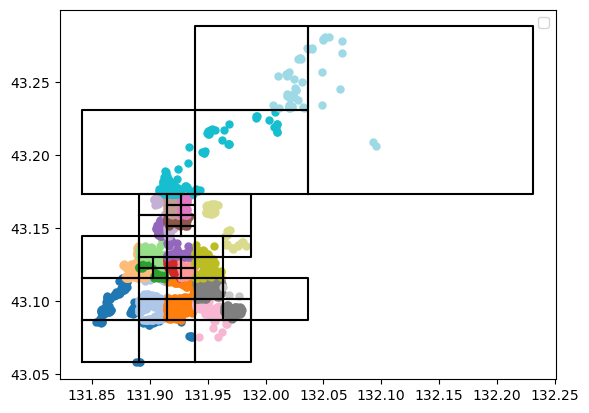

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

point = []
for j in cells[:,1] :
    point.append(j[['longitude','latitude']].to_numpy())
plt.figure()

num_regions = len(point)
print(num_regions)
color_map = cm.get_cmap('tab20')

for i, region_points in enumerate(point):
    x_coords, y_coords = region_points[:,0] ,region_points[:,1]
    color = color_map(i / num_regions) 
    plt.scatter(x_coords, y_coords, color=color, linewidths=0.01) #, label=f'Район {i+1}')

# Граничные точки
for cell in cells  :
    x_coords = [cell[3][0] , cell[3][1] , cell[3][1] , cell[3][0] ,cell[3][0]]
    y_coords = [cell[4][0] , cell[4][0] , cell[4][1] , cell[4][1] ,cell[4][0]]
    plt.plot(x_coords,y_coords , color= 'black')

plt.legend()
plt.show()

## Получим центры масс районов 


In [22]:
# regions = np.array([ j[['latitude' ,'longitude' ,'appartments']].to_numpy() for j in cells[:,1]])

centroids = []
for i,cell in enumerate(cells) :
    mass = cell[1]['appartments'].to_numpy().sum()
    x_coords = cell[1]['longitude'].to_numpy()
    y_coords = cell[1]['latitude'].to_numpy()
    apartments = cell[1]['appartments'].to_numpy()
    if mass > 0 : 
        centre_mass= [np.sum(x_coords*apartments)/mass , np.sum(y_coords*apartments)/mass , mass ,  {'lon':cell[3] , 'lat':cell[4]}]
        centroids.append(centre_mass)
        cells[i][0].mass_center = (centre_mass[0],centre_mass[1])  ; cells[i][1].mass_center = (centre_mass[0],centre_mass[1])
        cells[i][0].nearest_id = 'centroid n =' +str(i) ; cells[i][1].nearest_id = 'centroid n =' +str(i) 
        # np.append(cell , [centre_mass[0] ,centre_mass[1]] )
    else :
        centroids.append([ (cell[3][0]+cell[3][1])/2, (cell[4][0]+cell[4][1])/2 , mass , {'lon':cell[3] , 'lat':cell[4]}])
        # np.append(cell , [centre_mass[0] ,centre_mass[1]] )
        cells[i][0].mass_center = (centre_mass[0],centre_mass[1]) ; cells[i][1].mass_center = (centre_mass[0],centre_mass[1])  
        cells[i][0].nearest_id = 'centroid n =' +str(i) ; cells[i][1].nearest_id = 'centroid n =' +str(i)       
centroids[0]
cells[0][0].mass_center

/tmp/ipykernel_983464/1036701345.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  cells[i][0].mass_center = (centre_mass[0],centre_mass[1])  ; cells[i][1].mass_center = (centre_mass[0],centre_mass[1])
/tmp/ipykernel_983464/1036701345.py:18: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  cells[i][0].mass_center = (centre_mass[0],centre_mass[1]) ; cells[i][1].mass_center = (centre_mass[0],centre_mass[1])


(131.85591257360406, 43.08531095262267)

## Добавим центроиды в граф и соединим их с ближайшими дорогами

In [23]:
from shapely.geometry import LineString
graph_with_centroids = graph.copy()
nodes_to_display = []
edges_to_display = []
for i,vertex in enumerate(centroids):
    graph_with_centroids.add_node('centroid n =' +str(i),y =vertex[1],x = vertex[0],attr ={ 'mass' : vertex[2] , 'id_centroid' : i})
    nodes_to_display.append('centroid n =' +str(i))
    for neighbor in graph_with_centroids.nodes():
        node = graph_with_centroids.nodes()[neighbor]
        
        #Пускаем из центроиды района во все вершины района дороги одинакового размера
        if node['x'] < vertex[3]['lon'][1] and node['x'] > vertex[3]['lon'][0] and node['y'] < vertex[3]['lat'][1] and node['y'] > vertex[3]['lat'][0] : 
            if neighbor != 'centroid n =' +str(i) : #чтоб не было петлей
                nodes_to_display.append(neighbor)
                point1 = (vertex[0], vertex[1])
                point2 = (node['x'], node['y'])
                line1 = LineString([point1, point2]) ; line2 = LineString([point2, point1])
                graph_with_centroids.add_edge('centroid n ='+str(i) , neighbor, 'centroid n =' +str(i)+' to '+str(neighbor)  , length = 1 , attr = {'centroid_road':True}, geometry = line1)
                graph_with_centroids.add_edge(  neighbor , 'centroid n ='+str(i) ,str(neighbor)+' to '+ 'centroid n ='+str(i), length = 1, attr = {'centroid_road':True} , geometry = line2)
                edges_to_display.append(('centroid n ='+str(i),neighbor,{'geometry':line1}))
                edges_to_display.append((neighbor,'centroid n ='+str(i),{'geometry':line2}))

In [24]:
# # Добавим в cells - id центроид
# for i,cell in enumerate(cells) :


In [25]:
# for u, v, key, edge_data in graph_with_centroids.edges(keys=True, data=True):
#     # print(edge_data)
#     print(u,v,key)
#     # if 'attr' in edge_data.keys() :
#     #     print(edge_data)
#     #     # print(type(edge_data['geometry']))

Чекнем как выглядит все то что добавили 

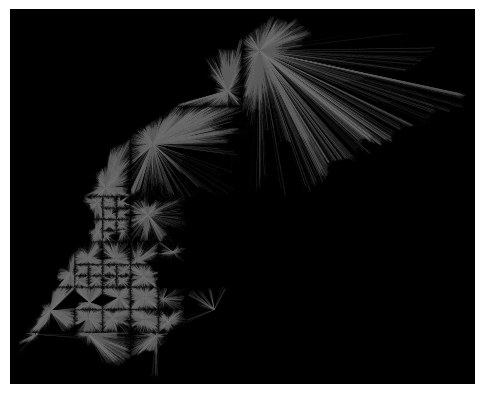

In [372]:
selected_digraph = graph_with_centroids.subgraph(nodes_to_display).copy()
selected_digraph.add_edges_from(edges_to_display)
fig, ax = ox.plot_graph(selected_digraph, node_size=0, edge_linewidth=0.01, bgcolor="k", figsize=(6, 6), show=False, close=False)
plt.show()

# node_coords = {node: (data['y'], data['x']) for node, data in graph.nodes(data=True)}
# north = max(coord[0] for coord in node_coords.values())
# south = min(coord[0] for coord in node_coords.values())
# east = max(coord[1] for coord in node_coords.values())
# west = min(coord[1] for coord in node_coords.values())
# truncated_graph = ox.truncate.truncate_graph_bbox(selected_digraph, north -0.01 , south + 0.02 , east , west)
# fig, ax = ox.plot_graph(truncated_graph, node_size=0, edge_linewidth=5.5, bgcolor="k", figsize=(10, 10), show=False, close=False)
# plt.show()

## Данные о компаниях

In [125]:
# import xml.etree.ElementTree as ET
# def print_xml_tree(elem, level=0):
#     indent = '  ' * level
#     print(f"{indent}{elem.tag} : {elem.attrib}")
#     for child in elem:
#         print_xml_tree(child, level + 1)
# xml_file = '/home/igoreshka/Desktop/VO_OTKRDAN_3_9965_9965_20230625_0a8950a3-08fc-4ec3-afa5-e3febc99b2d7.xml'
# tree = ET.parse(xml_file)
# root = tree.getroot()
# print_xml_tree(root)

In [373]:
# print('emp :' ,cells[0][0].keys())
# print('res :' ,(cells[0][1]).keys())
# print(cells[0][2])
# print(cells[0][3])

In [ ]:
# %%time
# from geopy.distance import geodesic
# # TODO use projections

# for cell_job, cell_res, cell_nodes,_ ,_ in cells:
#     for cell in cell_job, cell_res:
#         # n = cell.mass_center
#         # dists = cell_nodes.apply(lambda x : geodesic((x.lat, x.lon), (n[1], n[0])).km, axis=1)
#         # cell.nearest = cell_nodes.iloc[dists.argmin()] if dists.shape[0] > 0 else None
#         # Series got by iloc has all fields casted to float for some reason, so to keep int:
#         # cell.nearest_id = cell_nodes.node.iloc[dists.argmin()] if dists.shape[0] > 0 else None
        

## Сделаем переиндексацию графа перед построением корреспонденций

Чтобы в другом коде vladik_trips_parser скушал мой граф

In [26]:
# Реиндексация графа 
mapping = {}
iter = 0
for node in graph_with_centroids.nodes() :
    if type(node) == type(123) :
        mapping[node] = iter
        iter = iter + 1
for node in graph_with_centroids.nodes() :
    if type(node) != type(123) :
        mapping[node] = iter
        iter = iter + 1
graph_reindexed = nx.relabel_nodes(graph_with_centroids, mapping)

## По разбиениям строим кореспоненции

In [70]:
# L, W = {}, {}
# res_total = sum(cell_res.appartments.sum() for _,cell_res,_,_,_ in cells )
# emp_total = sum(cell_emp.emp.sum() for cell_emp, _, _ , _ ,_ in cells )
# print(emp_total, res_total)
# for cell_emp,cell_res ,_ ,_,_ in cells:
#     # print(cell_emp.nearest_id)
#     L[mapping[cell_emp.nearest_id]] = max(1, cell_emp.emp.sum())
# #     W[cell_res.nearest_id] = int(cell_res.area.sum() / res_total * emp_total)
#     # use one node for source and sink: division by zero in sinkhorn 
#     W[mapping[cell_emp.nearest_id]] = max(10, int(cell_res.appartments.sum() / res_total * emp_total))

    
# # del W[None]
# # del L[None]

# for k, v in W.items():
#     W[k] -= min(v-10, - sum(L.values()) + sum(W.values()), 100)

# print(sum(L.values()), sum(W.values()))

# trip_nodes, Ll, Wl = [], [], []
# for k in L.keys() | W.keys():
#     trip_nodes.append(k)
#     Ll.append(L[k] if k in L else 0)
#     Wl.append(W[k] if k in W else 0)

273095 164482.0
273095 273095


In [71]:
# print(L)
# print(W)
# print(Ll)
# print(Wl)

{72766: 195, 72767: 28762, 72768: 1939, 72769: 4416, 72770: 16745, 72771: 2048, 72772: 12327, 72773: 40363, 72774: 6338, 72775: 3354, 72776: 1724, 72777: 6284, 72778: 15068, 72779: 412, 72780: 1999, 72781: 1096, 72782: 762, 72783: 7450, 72784: 1682, 72785: 4274, 72786: 598, 72787: 1447, 72788: 56, 72789: 981, 72790: 3352, 72791: 2080, 72792: 435, 72793: 4362, 72794: 1764, 72795: 3178, 72796: 2896, 72797: 6274, 72798: 3146, 72799: 434, 72800: 1615, 72801: 2120, 72802: 788, 72803: 21516, 72804: 48522, 72805: 3816, 72806: 2237, 72807: 4240}
{72766: 988, 72767: 12130, 72768: 2528, 72769: 15422, 72770: 3770, 72771: 14385, 72772: 7981, 72773: 4524, 72774: 1891, 72775: 5206, 72776: 5675, 72777: 4360, 72778: 11383, 72779: 2732, 72780: 6493, 72781: 5251, 72782: 6561, 72783: 7395, 72784: 9986, 72785: 7727, 72786: 4790, 72787: 8899, 72788: 119, 72789: 3767, 72790: 4003, 72791: 6266, 72792: 3191, 72793: 3722, 72794: 1099, 72795: 14431, 72796: 16570, 72797: 13812, 72798: 288, 72799: 10, 72800: 1638

In [72]:
# for district in set(emp.district.values):
#     print(f'{district}:\t {emp[emp.district.apply(lambda x: x == district)].emp.sum()}') 

In [27]:
dis_works = {}
for i , cell in enumerate( cells ):
    dis_works[mapping['centroid n ='+str(i)]] = cell[0].emp.sum()
dis_works , sum(dis_works.values())

({72766: 195,
  72767: 28762,
  72768: 1939,
  72769: 4416,
  72770: 16745,
  72771: 2048,
  72772: 12327,
  72773: 40363,
  72774: 6338,
  72775: 3354,
  72776: 1724,
  72777: 6284,
  72778: 15068,
  72779: 412,
  72780: 1999,
  72781: 1096,
  72782: 762,
  72783: 7450,
  72784: 1682,
  72785: 4274,
  72786: 598,
  72787: 1447,
  72788: 56,
  72789: 981,
  72790: 3352,
  72791: 2080,
  72792: 435,
  72793: 4362,
  72794: 1764,
  72795: 3178,
  72796: 2896,
  72797: 6274,
  72798: 3146,
  72799: 434,
  72800: 1615,
  72801: 2120,
  72802: 788,
  72803: 21516,
  72804: 48522,
  72805: 3816,
  72806: 2237,
  72807: 4240},
 273095)

In [28]:
dis_residents = {}
for i , cell in enumerate( cells ):
    dis_residents[mapping['centroid n ='+str(i)]] = cell[1].appartments.sum()

print(sum(dis_works.values()) , sum(dis_residents.values()))

dis_residents_scaled = {}
for key, value in dis_residents.items():
    dis_residents_scaled[key] = int(value / sum(dis_residents.values()) * sum(dis_works.values()))
sum(dis_works.values()), sum(dis_residents_scaled.values())

273095 164482.0


(273095, 273078)

In [29]:
trip_nodes = []
for i ,centr in enumerate(centroids) :
    trip_nodes.append(mapping['centroid n ='+str(i) ] )
trips_nodes_dict = dict()
for value in trip_nodes :
    trips_nodes_dict[value] = [value] # Храним в общем случае массив : у района может быть несколько центроид



In [30]:
trip_nodes, L, W = [], [], []
for district, nodes in trips_nodes_dict.items():
    trip_nodes += nodes
    split = len(nodes)
    
    res = dis_residents_scaled[district]  
    l = [int(res / split)] * split
    l[-1] += res - sum(l)
    L += l
    
    work = dis_works[district]  
    w = [int(work / split)] * split 
    w[-1] += work - sum(w)
    W += w
    
print (trip_nodes, L, W, sep='\n')
    
# for district, target_nodes in trips_nodes_dict.items():
#     target_split = len(target_nodes)
        
    
sum(L), sum(W)

[72766, 72767, 72768, 72769, 72770, 72771, 72772, 72773, 72774, 72775, 72776, 72777, 72778, 72779, 72780, 72781, 72782, 72783, 72784, 72785, 72786, 72787, 72788, 72789, 72790, 72791, 72792, 72793, 72794, 72795, 72796, 72797, 72798, 72799, 72800, 72801, 72802, 72803, 72804, 72805, 72806, 72807]
[981, 12130, 2528, 15422, 3770, 14385, 7981, 4524, 1891, 5206, 5675, 4360, 11383, 2732, 6493, 5251, 6561, 7395, 9986, 7727, 4790, 8899, 119, 3767, 4003, 6266, 3191, 3722, 1099, 14431, 16570, 13812, 288, 0, 16387, 5716, 1499, 9744, 16503, 3159, 2012, 720]
[195, 28762, 1939, 4416, 16745, 2048, 12327, 40363, 6338, 3354, 1724, 6284, 15068, 412, 1999, 1096, 762, 7450, 1682, 4274, 598, 1447, 56, 981, 3352, 2080, 435, 4362, 1764, 3178, 2896, 6274, 3146, 434, 1615, 2120, 788, 21516, 48522, 3816, 2237, 4240]


(273078, 273095)

## Delete small roads

In [31]:
# nodes = ox.graph_to_gdfs(graph_with_centroids, nodes=True, edges=False)
# edges = ox.graph_to_gdfs(graph_with_centroids, nodes=False, edges=True)

result_graph = copy.deepcopy(graph_reindexed)

# Какие типы дорог хотим оставить

need_keys = ['length']
# highway_types = ["motorway", "trunk", "primary", "secondary",'service']

edges_to_remove = []
for u, v, key, edge_data in result_graph.edges(keys=True, data=True):
    # KEYS FILTER
    for need_key in need_keys :
        if need_key not in edge_data.keys() :
            edges_to_remove.append((u, v, key))
            break
    # HIGHWAY FILTER
    # if 'highway' not in edge_data.keys() :
    #     edges_to_remove.append((u, v, key))
    # else :
    #     if type(edge_data['highway']) == type(""):
    #         if edge_data['highway'] not in highway_types :
    #             edges_to_remove.append((u, v, key))
    #     else :
    #         for highway_type in edge_data['highway'] :
    #             if highway_type not in highway_types :
    #                 edges_to_remove.append((u, v, key))
    #                 break
for u, v, key in set(edges_to_remove):
    result_graph.remove_edge(u, v, key)

# Получение списка вершин без ребер
isolated_nodes = [node for node in result_graph.nodes() if result_graph.degree(node) == 0]

# Удаление вершин без ребер
result_graph.remove_nodes_from(isolated_nodes)

# ox.plot_graph(ox.project_graph(result_graph))

## Convert result graph to dataframe

In [32]:
df = pd.DataFrame(result_graph.edges(data=True),columns=['Init Node' , 'Term Node' , 'data'])
df['data'][22]

{'osmid': 23876689,
 'oneway': True,
 'lanes': '2',
 'highway': 'primary_link',
 'reversed': False,
 'length': 61.75,
 'geometry': <LINESTRING (131.936 43.113, 131.936 43.113, 131.936 43.113, 131.936 43.113,...>}

In [33]:
def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
graph_table = pd.DataFrame(result_graph.edges(data=True),columns=['init_node' , 'term_node' , 'data'])


graph_table['init_node_thru'] = graph_table['data'].apply(lambda x: True)
graph_table['term_node_thru'] = graph_table['data'].apply(lambda x: True)
# малые дороги : lanes = 1 
graph_table['capacity'] = graph_table['data'].apply(lambda x: x['lanes'] if 'lanes' in x.keys() and type(x['lanes']) != type([])  else 1.0 )

#maxspeed пока по дефолту 32 км/ч = 10 м/c --> Итоговая величина: сек
def getfreeflowtime(x) :
    return float(x['length'])/float(x['maxspeed'])*10/32 if 'maxspeed' in x.keys() and type(x['maxspeed']) == type("") and is_float(x['maxspeed']) else float(x['length'])/10 
graph_table['free_flow_time'] = graph_table['data'].apply(getfreeflowtime)

# graph_table['length'] = graph_table['data'].apply(lambda x: x['length'])
# graph_table['reversed'] = graph_table['data'].apply(lambda x: x['reversed'])
# graph_table['oneway'] = graph_table['data'].apply(lambda x: x['oneway'])


graph_table.drop('data', axis=1, inplace=True)

graph_table.head(10)


,init_node,term_node,init_node_thru,term_node_thru,capacity,free_flow_time
0,0,18694,True,True,1.0,1.786500
1,0,18669,True,True,4,0.011896
2,0,4218,True,True,4,13.745100
3,0,72770,True,True,1.0,0.100000
4,1,16243,True,True,1.0,0.996300
5,1,1953,True,True,4,1.730000
6,1,19400,True,True,4,5.817900
7,1,72770,True,True,1.0,0.100000
8,2,1899,True,True,4,1.248500
9,2,16263,True,True,1.0,1.827300


In [34]:
graph_table[graph_table['free_flow_time'] == 0 ]

,init_node,term_node,init_node_thru,term_node_thru,capacity,free_flow_time


In [35]:
# for j in graph_table.values.tolist() :
#     if type(j[0]) != type(12312) :
#         print(j)

## Кореспонденции
Список смежности : где находимся -->(сколько нас)--> куда хотим попасть 

In [36]:
# nodes = result_graph.nodes(data=True)
# nodes = np.array(nodes)
# print(nodes[0][0],nodes[0][1])

In [38]:
# graph_correspondences = dict()
# graph_correspondences[nodes[0][0]] = {'targets' : [nodes[4][0]],'corrs' : [100]}
# for i in range(1,30) :
#     graph_correspondences[nodes[i][0]] = {'targets' : [nodes[i-1][0]],'corrs' : [100]}
# print(graph_correspondences)

## Для теста 

In [39]:
# graph_data = {
#     'nodes number': len(result_graph.nodes(data=False))  , 
#     'links number' : len(result_graph.edges(data=False)) , 
#     'zones number' :  len(graph_correspondences),
#     'graph_table': graph_table
# }
# graph_correspondences
# total_od_flow = 100

## Для теста построения корреспонденций

In [40]:
graph_table.keys()

Index(['init_node', 'term_node', 'init_node_thru', 'term_node_thru',
       'capacity', 'free_flow_time'],
      dtype='object')

In [41]:


graph_table_name = '/home/igoreshka/Desktop/TransportNet_clone/TransportNet/Stable Dynamic & Beckman/data/graph_table_test.csv'
vl_trips_name = '/home/igoreshka/Desktop/TransportNet_clone/TransportNet/Stable Dynamic & Beckman/data/vl_trips_test.txt'

with open(vl_trips_name, 'w') as f:
    f.write('trip nodes, L, W\n')
    f.write(' '.join([str(n) for n in trip_nodes]) + '\n')
    f.write(' '.join([str(n) for n in L]) + '\n')
    f.write(' '.join([str(n) for n in W]) + '\n')

graph_table.to_csv(graph_table_name,sep = ' ')


просто сохранение графа

In [54]:
nodes_file = './data/nodes_graph.csv'
nodes_to_save = []
for i in result_graph.nodes() :
    nodes_to_save.append( (i ,result_graph.nodes()[i]['x'] , result_graph.nodes()[i]['y'] ))
nodes_to_save = pd.DataFrame(nodes_to_save , columns=['id','x','y'])
nodes_to_save.to_csv(nodes_file , sep=' ')